# Data gemeenteraadsverkiezingen 2022 Nederland

Dit notebook is voor het verwerken van de data van de gemeenteraadsverkiezingen van 2022. Er zal hier stap voor stap door de data gelopen worden om het proces reproduceerbaar te maken voor latere verkiezingen. De eerste stap was de data ophalen van de bronnen, zowel de overheid als waar is mijn stemlokaal (voor geografische data van de stemlokalen). De bronnen gebruikt voor de data zijn voor de verkiezingen van 2022 is als volgt:

- [Verkiezingsuitslagen Gemeenteraad 2022](https://data.overheid.nl/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43)
  - [Directe link naar uitslagen per gemeente CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_2022-03-29T15.14.zip)
  - [Directe link naar kandidatenlijst met uitslagen CSV](https://data.overheid.nl/sites/default/files/dataset/08b04bec-3332-4c76-bb0c-68bfaeb5df43/resources/GR2022_alle-kandidaten_2022-02-22T08.34.csv)
- [Waar is mijn stemlokaal stembureau data](https://waarismijnstemlokaal.nl/data)
  - [Directe link naar waar is mijn stemlokaal gemeenteraad 2022 CSV (CKAN)](https://ckan.dataplatform.nl/datastore/dump/d6a1b4c4-73c8-457b-9b75-a38428bded68)
  - [Verkiezingsuitslagen gemeenteraadsverkiezingen 2022 geodata (Volkskrant)](https://data.openstate.eu/dataset/verkiezingsuitslagen-gemeenteraadsverkiezingen-2022)
    - [Directe link naar GEOJSON bestand](https://data.openstate.eu/dataset/a1767f1b-bf0c-409b-b3b1-3af9954b57f4/resource/413be255-5070-48f4-b631-895097976abb/download/2022gr.geo.json)
- [CBS Wijk- en buurtkaart 2021](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2021)
  - [Directe link naar zip bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip)
- [CBS bevolkingsdichtheid kaart 100 bij 100 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-100-meter-bij-100-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/100/nl_vierkant_100meter_bij_100meter.7z)
- [CBS bevolkingsdichtheid kaart 500 bij 500 meter](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/kaart-van-500-meter-bij-500-meter-met-statistieken)
  - [Directe link naar 7z bestand met SHP bestand er in](https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/vierkanten/500/2021-cbs_vk500_2020_v1.zip)

De eerste stap die we moeten maken is de data importeren voor de analyse, daarna kunnen we kijken hoe goed de data is, hoe we het aan kunnen vullen, en wat er mee te doen. De makkelijkste structuur die we vonden was het geojson bestand van open state en de Volkskrant, daar staan alle stembureaus al in een lijst, en we hebben een makkelijk framework om het te importeren; geopandas. We laden deze dan ook als eerste in.

In [2]:
import pandas as pd
import geopandas as gpd

crs = {'init':'EPSG:4326'}
df_geojson = gpd.read_file(r'../data/2022gr.geo.json', crs=crs)

/home/lillian/.local/lib/python3.9/site-packages/fiona/collection.py:208: FeatureWarning: Empty field name at index 61
  self._schema = self.session.get_schema()
/home/lillian/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: UserWarning: Empty field name at index 61
  for feature in features_lst:


We importeren nu de gemeente shapefile kaart van het CBS, om de overlay van onze stemlokalen eroverheen te kunnen doen. 

<AxesSubplot:>

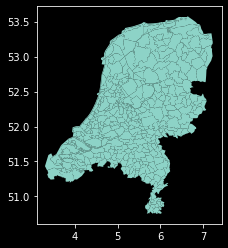

In [29]:
nl_map = gpd.read_file(r'../data/shape/Netherlands_shapefile/gemeente_2021_v1.shp')
nl_map.to_crs(epsg=4326).plot()


In [4]:
print(nl_map)

    GM_CODE            GM_NAAM  H2O       OAD      STED  BEV_DICHTH  AANT_INW  \
0    GM0034             Almere   JA -99999999 -99999999   -99999999 -99999999   
1    GM0050           Zeewolde   JA -99999999 -99999999   -99999999 -99999999   
2    GM0060            Ameland   JA -99999999 -99999999   -99999999 -99999999   
3    GM0072          Harlingen   JA -99999999 -99999999   -99999999 -99999999   
4    GM0088    Schiermonnikoog   JA -99999999 -99999999   -99999999 -99999999   
..      ...                ...  ...       ...       ...         ...       ...   
430  GM1966       Het Hogeland  NEE       414         5          99     47834   
431  GM1969     Westerkwartier  NEE       476         5         176     63678   
432  GM1970  Noardeast-Fryslân  NEE       463         5         120     45481   
433  GM1978        Molenlanden  NEE       393         5         243     44130   
434  GM1979          Eemsdelta  NEE       692         4         170     45587   

     AANT_MAN  AANT_VROUW  

<AxesSubplot:>

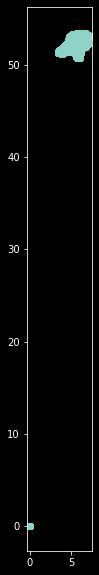

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson.plot(ax=ax)

We hebben hier een probleem dat sommige punten de coördinaten 0,0 hebben, dit is niet iets wat we willen weergeven. Laten we eerst kijken waarom dit het geval is in de data voordat we het er helemaal uithalen.

In [6]:
for index, row in df_geojson.iterrows():
    if (row.geometry.centroid.x == 0.00000):
        print(row)

Stembureau                                                            32
Adres                                                                   
Locatie                                                             SB32
description                               Stembureau Mobiel Stembureau 1
Geldige stemmen                                                       99
                                                       ...              
"Leefbaar 's-Hertogenbosch" Paul Kagie                               NaN
RAADSGROEPERING ''BOSCH-BELANG''                                     NaN
gewoon ge-DREVEN                                                     NaN
VOOR Den Bosch Joep Gersjes                                          NaN
geometry                                                     POINT (0 0)
Name: 2520, Length: 973, dtype: object
Stembureau                                                            33
Adres                                                                   
Locatie     

Het zijn dus duidelijk allemaal mobiele stembureaus, die kunnen we in een aparte dataset houden voor later, voor nu zijn ze onbelangrijk voor de kaartweergave, laten we de dataset dus opsplitsen in drie dataframes, de originele, één frame zonder de mobiele stembureaus, en de mobiele stembureaus alleen.

In [7]:
#de waarschuwing over de projectie die niet klopt kan genegeerd worden, we zoeken naar data die x = 0 is, de projectie gaat geen effect hebben op die data in Nederland
#filter de data en print welke waardes 0 hebben op x
mobiel_mask = df_geojson['geometry'].centroid.x == 0
i = 0
for item in mobiel_mask:
    if item:
        print(i)
    i = i + 1

/tmp/ipykernel_11867/291552514.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mobiel_mask = df_geojson['geometry'].centroid.x == 0


2520
2521
2918
3579
3580
3581
3582
3583
5494
5784
5785
6260
6261
6738
6739
6863
7348
7364
7857
7912
7913
7923
7924
7926
7958
7959
7960
8108
8109
8161
8162
8163
8318
9093
9151
9152
9153
9661
9853
10427
10431
10497
10498
10525
10526
10527
10528
10623
10624
10894
10895
11032
11101
12038
12039
12053
12054
12118
12119
12120
12121
12504
12505
12506


In [8]:
df_geojson_clean = df_geojson[~mobiel_mask]
df_geojson_mobiel = df_geojson[mobiel_mask]
print(df_geojson_clean)

       Stembureau   Adres Locatie  \
0               1  9461BH     SB1   
1               2  9461DA     SB2   
2               3  9461JA     SB3   
3               4  9451KD     SB4   
4               6  9454PL     SB6   
...           ...     ...     ...   
12591         703  5391AR   SB703   
12592         705  5391AR   SB705   
12593         750  5382KE   SB750   
12594         751  5382KE   SB751   
12595         752  5283KE   SB752   

                                             description  Geldige stemmen  \
0      Stembureau Gemeentehuis Gieten (postcode: 9461...              784   
1              Stembureau OBS Gieten (postcode: 9461 DA)              562   
2      Stembureau Zorgcentrum Dekelhem (postcode: 946...              566   
3      Stembureau Ontmoetingscentrum Boerhorn Rolde (...             1495   
4      Stembureau Dropshuis de Eekhof (postcode: 9454...              347   
...                                                  ...              ...   
12591  Stemburea

<AxesSubplot:>

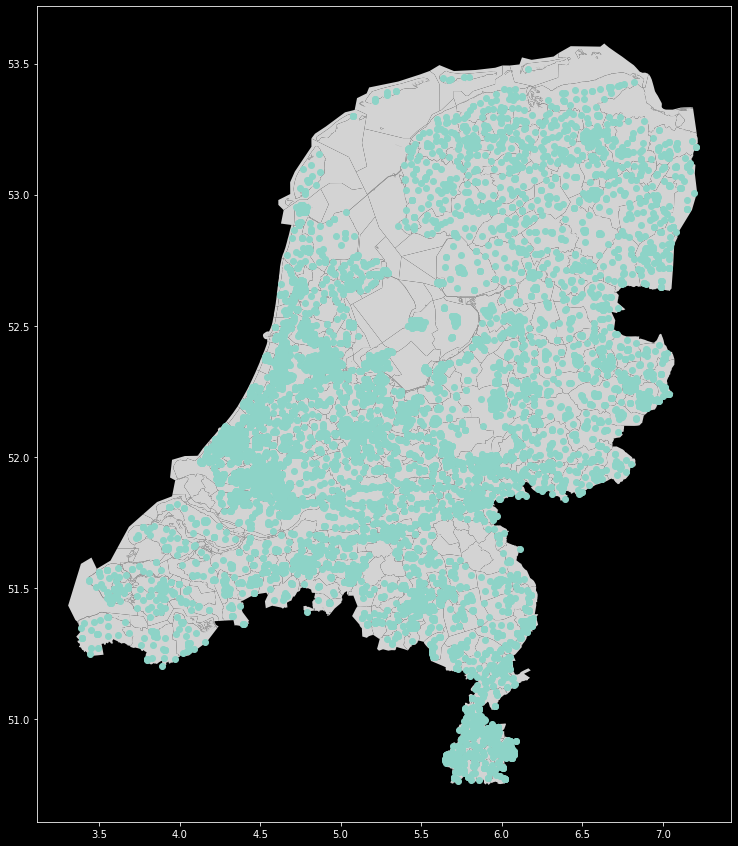

In [9]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

Nu we een mooie kaart hebben van nederland met de stemlokalen erop, kunnen we gaan kijken naar hoe dit verhoud met de bevolkingsdichtheid als eerste voorbeeld. De kaart is opgehaald van het CBS, eerst gaan we kijken hoe de kaart er op zichzelf met dezelfde projectie uitziet.

<AxesSubplot:>

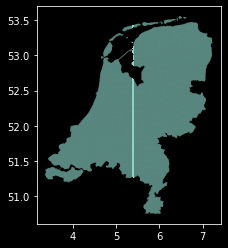

In [10]:
nl_map_cbs = gpd.read_file(r'../data/shape/Netherlands_shapefile/CBS_vk500_2020_v1.shp')
nl_map_cbs.to_crs(epsg=4326).plot()

Het verwerken van de 500m bij 500m vierkanten kaar duurde heel lang (langer dan een half uur) op de laptop, en is dus niet ideaal tenzij we dit niveau van detail écht nodig hebben. Er is namelijk nog een andere kaart met dezelfde gegevens beschikbaar, maar met een grid van 500 bij 500 meter in plaats van 100 bij 100. Laten we dus kijken hoe vaak een stemlokaal dichterbij dan 100 meter van de dichtstbijzijnde andere is. De makkelijkste manier om dat te doen zonder alle punten met alle andere te vergelijken (heel veel moeite), is een extra dataframe maken als een kopie, alle indexen 1 opschuiven (want alle stemlokalen zijn al in een volgorde van clustering), en dan de laagste afstand bekijken.

In [11]:
df_shifted = df_geojson_clean.to_crs('EPSG:28992')

df_shifted['geometry (shifted)'] = df_shifted['geometry'].shift(periods=1)
df_shifted['distance'] = df_shifted['geometry'].distance(df_shifted['geometry (shifted)'])
df_shifted.sort_values(['distance'], inplace=True, ascending=True)
zero_mask_booth = df_shifted['distance'] == 0.000000
df_shifted = df_shifted[~zero_mask_booth]
print(df_shifted['distance'])

11165         0.002608
1021          0.004853
3196          0.004875
1923          2.693202
3757          3.609362
             ...      
7444     253385.654588
9711     263408.187856
4392     266925.200994
9297     271954.076837
0                  NaN
Name: distance, Length: 11670, dtype: float64


We kunnen dus vaststellen dat afstanden van onder de 500 meter waarschijnlijk zeldzaam zijn, en we verder kunnen gaan met de 500 meter bij 500 meter kaart. Laten we nu dus een projectie proberen te maken met de bevolkingsdichtheid erop om het te vergelijken met de stemlokalen en hun posities en clustering.

In [12]:
print(list(nl_map_cbs))
nl_map_dst = nl_map_cbs.drop(columns=['MAN', 'VROUW', 'INW_014', 'INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL', 'P_NL_ACHTG', 'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK', 'HH_EENOUD', 'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45', 'WON_4564', 'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514', 'WON_1524', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP', 'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED'])
zero_mask_pop = nl_map_dst['INWONER'] == -99997
nl_map_dst = nl_map_dst[~zero_mask_pop]
nl_map_dst

['c28992r500', 'INWONER', 'MAN', 'VROUW', 'INW_014', 'INW_1524', 'INW_2544', 'INW_4564', 'INW_65PL', 'P_NL_ACHTG', 'P_WE_MIG_A', 'P_NW_MIG_A', 'AANTAL_HH', 'TOTHH_EENP', 'TOTHH_MPZK', 'HH_EENOUD', 'HH_TWEEOUD', 'GEM_HH_GR', 'WONING', 'WONVOOR45', 'WON_4564', 'WON_6574', 'WON_7584', 'WON_8594', 'WON_9504', 'WON_0514', 'WON_1524', 'WON_MRGEZ', 'P_KOOPWON', 'P_HUURWON', 'WON_HCORP', 'WON_NBEW', 'WOZWONING', 'UITKMINAOW', 'OAD', 'STED', 'geometry']


,c28992r500,INWONER,geometry
267,E2050N6110,5,"POLYGON ((205000.000 611500.000, 205500.000 61..."
269,E2060N6110,15,"POLYGON ((206000.000 611500.000, 206500.000 61..."
292,E2055N6105,20,"POLYGON ((205500.000 611000.000, 206000.000 61..."
293,E2060N6105,185,"POLYGON ((206000.000 611000.000, 206500.000 61..."
294,E2065N6105,340,"POLYGON ((206500.000 611000.000, 207000.000 61..."
...,...,...,...
151071,E1970N3075,10,"POLYGON ((197000.000 308000.000, 197500.000 30..."
151073,E1980N3075,90,"POLYGON ((198000.000 308000.000, 198500.000 30..."
151074,E1985N3075,15,"POLYGON ((198500.000 308000.000, 199000.000 30..."
151100,E1980N3070,5,"POLYGON ((198000.000 307500.000, 198500.000 30..."


In [13]:
import folium
from folium import plugins

map = folium.Map(location = [52.155, 5.3875], zoom_start = 9, tiles="cartodbdark_matter", prefer_canvas=True)

nl_map_dst.to_crs(epsg=4326)
#Make sure the index is a string so folium can read it correctly as a key.
nl_map_dst['c28992r500'] = nl_map_dst['c28992r500'].apply(lambda x: str(x))

folium.Choropleth(
    geo_data = nl_map_dst,
    name="Bevolkingsdichtheid",
    data = nl_map_dst,
    columns = ["c28992r500", "INWONER"],
    key_on = 'feature.properties.c28992r500',
    fill_color = 'RdPu',
    nan_fill_color= 'white',
    fill_opacity = 0.7,
    nan_fill_opacity = 0.7,
    line_opacity = 0,
    legend_name = 'Bevolkingsdichtheid',
    smooth_factor = 1.0,
    show=False
).add_to(map)

# Renders the map to an HTML file and displays it in an embed.
def embed_map(m):
    #from IPython.display import IFrame
    m.save('index.html')
    #return IFrame('index.html', width='100%', height='750px')

In [14]:
df_geojson_clean_hmp = [[point.xy[1][0], point.xy[0][0]] for point in df_geojson_clean.geometry]

plugins.HeatMap(df_geojson_clean_hmp, name="Stemlokalen Heatmap").add_to(map)

folium.LayerControl().add_to(map)



embed_map(map)




We kunnen zien dat er gemeente zijn die geen stemlokalen hebben, dit klopt. [In de verkiezingen van 2022 hebben 12 gemeentes niet meegedaan](https://nl.wikipedia.org/wiki/Nederlandse_gemeenteraadsverkiezingen_2022). Er zijn dus in totaal 333 gemeentes met stemlokalen. We willen de bevolkingsdichtheiddata van de gemeentes die niet meededen dus weggooien, hiervoor moeten we eerst kijken welke alleen binnen de gemeentes vallen die we niet willen houden.

In [39]:
print(df_geojson['electionName'])

#get all municipalities that are in the election
gemeentes = df_geojson['electionName'].str.slice(13, -5).drop_duplicates()
print(gemeentes)

0             Gemeenteraad Aa en Hunze 2022
1             Gemeenteraad Aa en Hunze 2022
2             Gemeenteraad Aa en Hunze 2022
3             Gemeenteraad Aa en Hunze 2022
4             Gemeenteraad Aa en Hunze 2022
                        ...                
12591    Gemeenteraad 's-Hertogenbosch 2022
12592    Gemeenteraad 's-Hertogenbosch 2022
12593    Gemeenteraad 's-Hertogenbosch 2022
12594    Gemeenteraad 's-Hertogenbosch 2022
12595    Gemeenteraad 's-Hertogenbosch 2022
Name: electionName, Length: 12596, dtype: object
0             Aa en Hunze
27               Aalsmeer
46                 Aalten
74          Achtkarspelen
95           Alblasserdam
               ...       
11976     Zwartewaterland
11997         Zwijndrecht
12031              Zwolle
12122       's-Gravenhage
12495    's-Hertogenbosch
Name: electionName, Length: 333, dtype: object


In [47]:
#First let's remove the municipalities that don't have an Election from the municipality map
remove_lst = ["Boxtel", "Eemsdelta", "Oisterwijk", "Vught", "Heerhugowaard", "Langedijk", "Boxmeer", "Cuijk", "Sint Anthonis", "Mill en Sint Hubert", "Grave", "Landerd", "Uden", "Brielle", "Hellevoetsluis", "Westvoorne", "Purmerend", "Beemster", "Weesp"]

nl_map_clean = nl_map[~nl_map["GM_NAAM"].isin(remove_lst)]
nl_map_clean = nl_map_clean.query("H2O != 'JA'")
nl_map_clean = nl_map_clean.query("GM_NAAM != 'Buitenland'")

nl_map_election = nl_map[nl_map["GM_NAAM"].isin(gemeentes)]
nl_map_election = nl_map_election.query("H2O != 'JA'")

print("Shape of clean: {}".format(nl_map_clean.shape))
print("Shape of election: {}".format(nl_map_election.shape))

diff = pd.concat([nl_map_election, nl_map_clean]).drop_duplicates(keep=False)
diff

Shape of clean: (333, 38)
Shape of election: (330, 38)


,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
113,GM0164,Hengelo,NEE,1845,2,1332,81049,40776,40273,15,...,6,7,6183,6084,99,2021GM0164,2021,47510.255914,6.183056e+07,"POLYGON ((251978.591 481220.258, 251979.382 48..."
191,GM0373,Bergen (NH.),NEE,819,4,300,29715,14317,15398,12,...,0,3,12023,9896,2127,2021GM0373,2021,57488.474563,9.987418e+07,"POLYGON ((105976.650 529056.951, 106002.347 52..."
328,GM0893,Bergen (L.),NEE,318,5,127,13108,6568,6540,13,...,0,3,10850,10324,525,2021GM0893,2021,61497.563571,1.084951e+08,"POLYGON ((199768.270 409749.960, 199758.060 40..."


Nu we dezelfde lijst hebben van gemeentes die in de verkiezingen meededen kunnen we verder.

<AxesSubplot:>

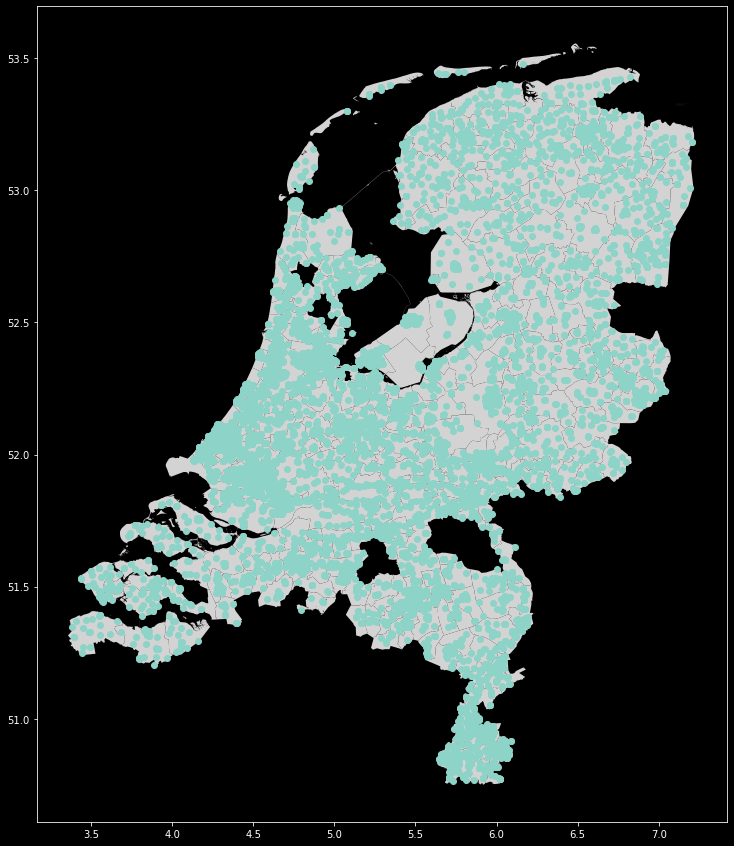

In [50]:
fig, ax = plt.subplots(figsize = (15,15))
nl_map_clean.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
df_geojson_clean.plot(ax=ax)

In [16]:
nl_map_dst_points = nl_map_dst
nl_map_dst_points['geometry'] = nl_map_dst_points['geometry'].centroid
nl_map_dst_points.head()

,c28992r500,INWONER,geometry
267,E2050N6110,5,POINT (205250.000 611250.000)
269,E2060N6110,15,POINT (206250.000 611250.000)
292,E2055N6105,20,POINT (205750.000 610750.000)
293,E2060N6105,185,POINT (206250.000 610750.000)
294,E2065N6105,340,POINT (206750.000 610750.000)


In [17]:
import numpy as np

from scipy.spatial import cKDTree
from shapely.geometry import Point
#Found on https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
def ckdnearest(gdA, gdB):

    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

#error bar is +- sqrt(250²*2)m ≈ +-353.553390593m
df_nearest = ckdnearest(nl_map_dst_points.to_crs(epsg=28992), df_geojson_clean.to_crs(epsg=28992))
df_nearest.head()



,c28992r500,INWONER,geometry,Stembureau,Adres,Locatie,description,Geldige stemmen,Opgeroepen,Ongeldig,...,Nationale Bond tegen Overheidszaken - DH,Haags Belang,INL Den Haag,Rosmalens Belang,De Bossche Groenen,"""Leefbaar 's-Hertogenbosch"" Paul Kagie",RAADSGROEPERING ''BOSCH-BELANG'',gewoon ge-DREVEN,VOOR Den Bosch Joep Gersjes,dist
0,E2050N6110,5,POINT (205250.000 611250.000),1,9166LX,SB1,Stembureau Gemeentehuis (postcode: 9166 LX),655,827,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331.950309
1,E2060N6110,15,POINT (206250.000 611250.000),1,9166LX,SB1,Stembureau Gemeentehuis (postcode: 9166 LX),655,827,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,688.536284
2,E2055N6105,20,POINT (205750.000 610750.000),1,9166LX,SB1,Stembureau Gemeentehuis (postcode: 9166 LX),655,827,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,672.375861
3,E2060N6105,185,POINT (206250.000 610750.000),1,9166LX,SB1,Stembureau Gemeentehuis (postcode: 9166 LX),655,827,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228.220493
4,E2065N6105,340,POINT (206750.000 610750.000),1,9166LX,SB1,Stembureau Gemeentehuis (postcode: 9166 LX),655,827,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.974214


Text(0, 0.5, 'Bevolking')

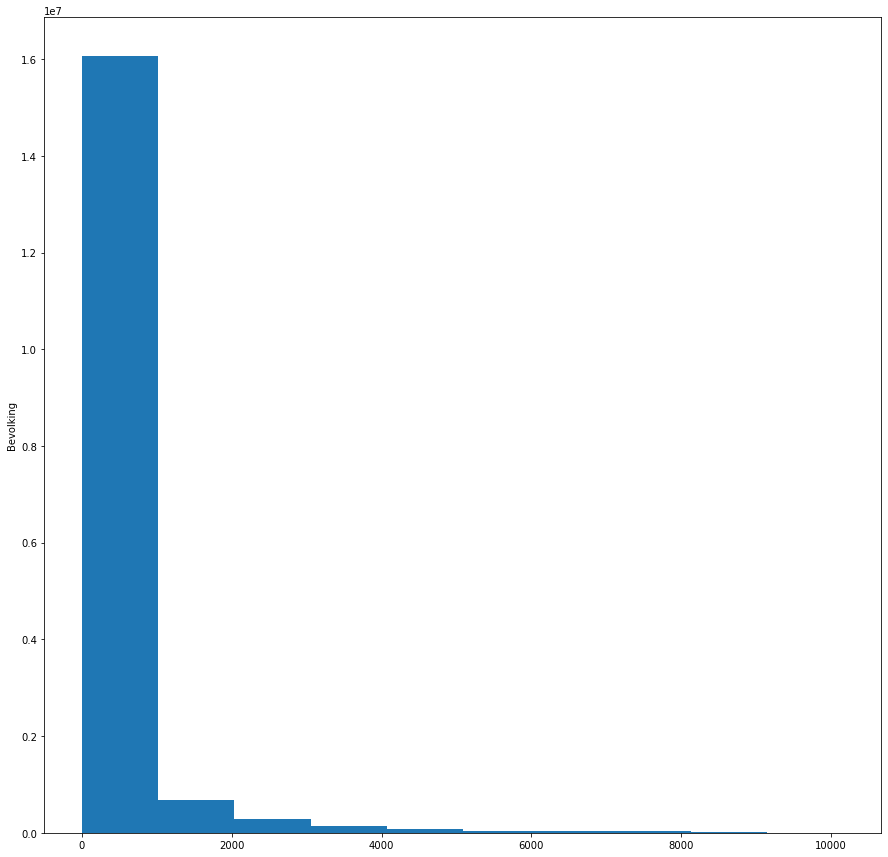

In [18]:

#TODO: filter out municipalities that don't have an election in 2022
df_nearest['dist'].plot(kind="hist", weights=df_nearest['INWONER'], figsize=(15,15), density=False).set_ylabel('Bevolking')

Het was mooier geweest als we het konden filteren op alleen stemgerechtigden en niet op de gehele populatiedichtheid, maar het CBS geeft geen data vrij die daarbij helpt. Er is een categorie voor 0-14 jaar oude mensen, maar niet alle minderjarigen of niet stemgerechtigde. Het moet dus maar met totale bevolkingsdichtheid om een idee te krijgen.

In [19]:
df_wims = pd.read_csv(r'../data/wims.csv')
print(df_wims)

        _id      Gemeente CBS gemeentecode  Nummer stembureau  \
0         1  Valkenswaard           GM0858                  1   
1         2  Valkenswaard           GM0858                  2   
2         3  Valkenswaard           GM0858                  3   
3         4  Valkenswaard           GM0858                  4   
4         5  Valkenswaard           GM0858                  5   
...     ...           ...              ...                ...   
9236  38711        Putten           GM0273                  3   
9237  38712        Putten           GM0273                 10   
9238  38713        Putten           GM0273                  8   
9239  38714        Putten           GM0273                 13   
9240  38715        Putten           GM0273                  6   

                        Naam stembureau  \
0                 Zorgcentrum Kempenhof   
1                Buurtgebouw De Horizon   
2                   Speeltuin Geenhoven   
3     Ontmoetingscentrum De zoete inval   
4   

In [20]:
#de eerste vijf rijen zijn meta-data en kunnen we gerust weghalen voor nu 
df_gr_gr = pd.read_csv(r'../data/stemmen/01_Groningen/osv4-3_telling_gr2022_groningen.csv', skiprows=5, header=None, delimiter=';')
print(df_gr_gr)


              0                    1           2                3       4    \
0     Lijstnummer           Aanduiding  Volgnummer   Naam kandidaat  Totaal   
1    Gebiednummer                  NaN         NaN              NaN     NaN   
2        Postcode                  NaN         NaN              NaN     NaN   
3             NaN         opgeroepenen         NaN              NaN  194113   
4             NaN      geldige stempas         NaN              NaN   96830   
..            ...                  ...         ...              ...     ...   
445           NaN                  NaN           5     Oetomo, A.D.      38   
446           NaN                  NaN           6         Smid, D.      25   
447           NaN                  NaN           7  van Welij, P.Z.      10   
448            16  Blanco (Dokter, T.)         NaN              NaN     100   
449           NaN                  NaN           1       Dokter, T.     100   

                                5    \
0    GRID Gr

De data is heel gecompliceerd, dus we moeten het bruikbaar maken in pandas. Met hoe de data eruit ziet in een CSV in libre office willen we een constructie maken van de verschillende onderdelen. We hebben de data van de stemlokalen apart al, die kunnen we dus negeren. We willen de data van de lijsten apart hebben. 

In [21]:

#TODO:mobiele stemlokalen eruit filteren die NIET 0,0 zijn
#TODO:datastandaard duitse verkiezingen stemlokaalafstand opzoeken